## Steel price regression - 환율 선 적용

## 변수 정의
### 1. 국내
* weightA: 철 스크랩, 중량A 평균가

### 2. 철스크랩(Scrap Steel) > 한국의 수입가
* importPriceUSA: 미국산 대형 -벌크 (HMS No.1) (달러/톤)
* importPriceJP: 일본 H2 (백엔/톤)

### 3. 철스크랩(Scrap Steel) > 해외가격(Overseas)
* priceCN: 중국 장쑤 내수가 (달러/톤)
* priceJP: 일본 내수가 (백엔/톤)
* priceUSA_TAIWAN : 미국→대만 (컨테이너) (달러/톤)

### 4. 기타 변수
* stock: 국내 제강사 재고
* USD_KR: 달러 환율(해당일 매매기준율)
* JPY_KR: 엔화 환율(해당일 매매기준율)


### Scrap가 부서공식 
* 스크랩가 = weightA*0.7 + importPriceJP*0.2 + importPriceUSA*0.1

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Random Forest
from sklearn.ensemble import RandomForestClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV
# 모델 성능 평가
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot,add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
import matplotlib
# 한글설치 (윈도우 버전)
matplotlib.rc('font', family = 'AppleGothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')
random_seed = 123
pd.set_option('display.max_rows', 500)

In [6]:
def transform_df(_df):
    #날짜형으로 변환
    _df['date'] = pd.to_datetime(_df['date'], format='%Y-%m-%d')
    # 계산을 위해 YEAR-Quarter 컬럼 추가 (값 형태 year.quarter)
    _df['quarter'] = _df['date'].dt.year+ (_df.date.dt.quarter)*0.1
    #Unit 단위 통일 톤/원
    _df['weightA']= _df['weightA'] * 1000
    _df['gosi'] = _df['gosi'] * 1000
    #부서 고유공식(1) 적용된 스크랩가 구하기
    _df['scrap'] = _df['weightA']*0.7 + _df['importPriceJP']*0.2 + _df['importPriceUSA']*0.1
    return _df

In [35]:
# 시계열 모델에서 예측된 각각의 값들
df = pd.read_csv("./data/input_step1_p50.csv")
df = transform_df(df)
df_a = df.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df.groupby(['quarter'])['scrap'].mean().reset_index()


In [36]:
#분기처리를 위한 배열
mr = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
def get_quarter(m):
    if m >= 1 and m <= 3:
        return 1
    elif m >= 4 and m <= 6:
        return 2
    elif m >= 7 and m <= 9:
        return 3
    elif m >= 10 and m <= 12:
        return 4

def get_sgap(row):
    month = row.month #current month
    year = row.year
    if month % 3 == 0 : # 3, 6, 9, 12
        # *9월 = (7, 8월의 스크랩평균가)의 평균가가 전분기 대비 5% +- 상관없이 변동되었을 때.
        #(같은 분기 7월) 고시가 + [(7, 8월의 스크랩평균가) - (전분기, 2분기 스크랩평균가)]
        df_year = df[df['date'].dt.year == year]
        mean1 = df_year[df_year['date'].dt.month == month - 1].scrap.mean()
        mean2 = df_year[df_year['date'].dt.month == month - 2].scrap.mean()
        scrap_mean = (mean1 + mean2) / 2
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        q1 = get_quarter(month) - 1
        if q1 == 0:
            year = year - 1
            q1 = 4
        try:
            previous_q1_mean_scrap = df_b[df_b.quarter == year + q1 * 0.1]['scrap'].values[0]
                       
            return same_quarter_price+ (scrap_mean - previous_q1_mean_scrap)
        except IndexError:
            return -1

    elif month % 3 == 1 : # 1 4 7 10
        # 7월 =전분기의 고시가인 4월 고시가 + [ 4,5,6(2분기) 스크랩 평균가  - 1분기 스크랩평균가 ] ​
        q1 = get_quarter(month) - 1
        previous_q1_mean_scrap = 0
        previous_q2_mean_scrap = 0
        previous_quarter_price = 0
        try:  
            previous_quarter_price  = df[df.quarter == year+0.1*(row.quarter-1)][-1:]['gosi'].values[0]
        except IndexError:
            previous_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        try:  
            if q1 == 0:
                year = year - 1
                q2 = 4
                q1 = 3
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
            elif q1 == 1: # 4 month, 
                print(month)
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']  
                year = year -1
                q2 = 4
            else:
                previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap'] 
                q2 = q1 - 1
            previous_q2_mean_scrap = df_b[df_b.quarter == (year+q2*0.1)]['scrap']
            print("%d-%d ( %d %d )"%(year, month, q1, q2))
            a = previous_q1_mean_scrap.values[0]
            b = previous_q2_mean_scrap.values[0]
            result = previous_quarter_price + (a - b)
            compared_5percent = 0
            if abs(previous_quarter_price- result)> previous_quarter_price*0.05:
             compared_5percent =  previous_quarter_price
            else:
                compared_5percent = result
            if len(previous_q1_mean_scrap) > 0 and len(previous_q2_mean_scrap) > 0 :
                return compared_5percent
            else: return -1
        except TypeError:  
            return -2
        except Exception:
            return -3
    else : # 2 5 8 11
        # *8월 = 7월의 스크랩평균가가 전분기 대비 5% 변동되었을 경우,
        #(같은 분기의 7월) 고시가 + [( 7월 스크랩 평균가 ) -(전분기, 2분기 스크랩평균가) ]
        df_year = df[df['date'].dt.year == year]
        mean1 =  df_year[df_year['date'].dt.month == month-1 ].scrap.mean()
        same_quarter_price = df[df.quarter == year+0.1*row.quarter][-1:]['gosi'].values[0]
        q1 = get_quarter(month)-1        
        if q1 == 0:
            year = year-1
            q1 = 4
        previous_q1_mean_scrap = df_b[df_b.quarter == (year+q1*0.1)]['scrap']
        compared_5percent = 0
        result = 0
        if len(previous_q1_mean_scrap.values) > 0:
            result = same_quarter_price + (mean1 - previous_q1_mean_scrap.values)[0]
        else : 0
        if abs(same_quarter_price- result)> same_quarter_price*0.05:
            compared_5percent =same_quarter_price
        else :
            compared_5percent = result
        
        return compared_5percent
        


In [55]:
dfa = pd.DataFrame()
dfa['scrap_gap_50'] = df['date'].apply(get_sgap)
#df = df[df['scrap_gap_50']>0] 

2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

In [59]:


df_p90 = pd.read_csv("./data/input_step1_p90.csv") 
df = transform_df(df_p90)
df_a = df_p90.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_p90.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_90'] = df['date'].apply(get_sgap)

df_p10 = pd.read_csv("./data/input_step1_p10.csv")
df = transform_df(df_p10)
df_a = df_p10.groupby(['quarter'])['gosi'].mean().reset_index()
df_b = df_p10.groupby(['quarter'])['scrap'].mean().reset_index()
dfa['scrap_gap_10'] = df_p10['date'].apply(get_sgap)


2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
2016-1 ( 3 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
4
2016-4 ( 1 4 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-7 ( 2 1 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-10 ( 3 2 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
2017-1 ( 3 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
4
2017-4 ( 1 4 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-7 ( 2 1 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-10 ( 3 2 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
2018-1 ( 3 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
4
2018-4 ( 1 4 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-7 ( 2 1 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-10 ( 3 2 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
2019-1 ( 3 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
4
2019-4 ( 1 4 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-7 ( 2 1 )
2020-10 ( 3 2 )
2020-10 ( 3 2 )
2020-10 ( 

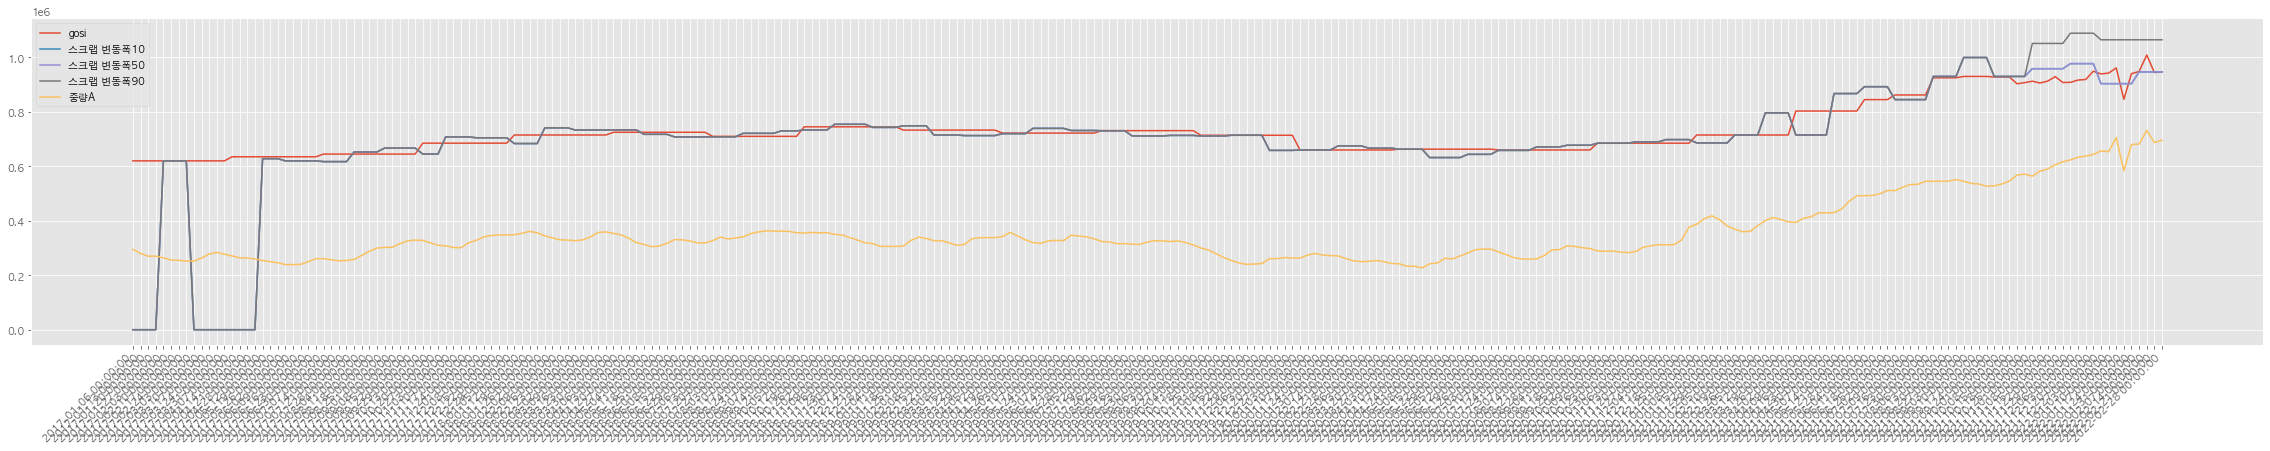

In [61]:


#df['scrap_gap_90'] = df_p90[df_p90['scrap_gap']>0]

import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (40,6)
xi = list(range(len(df)))
fig = plt.figure()
ay= fig.add_subplot(111)
ay.plot(df.index, df['gosi'], label = 'gosi')

ay.plot(df.index, dfa['scrap_gap_10'] , label = '스크랩 변동폭10')
ay.plot(df.index, dfa['scrap_gap_50'] , label = '스크랩 변동폭50')
ay.plot(df.index, dfa['scrap_gap_90'] , label = '스크랩 변동폭90')
ay.plot(df.index, df['weightA'], label='중량A')
plt.xticks(xi, df['date'])
plt.legend()
ay.set_xticklabels(df['date'], rotation = 45, ha="right")
plt.show()
fig.savefig('./result_img01/fig2_50.png', dpi = 100)
